In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from models.CNN_SE_model import CNN_SE
from models.CNN_model import CNN
from copy import deepcopy
from tqdm import tqdm
import time
from datetime import datetime, timedelta

In [2]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

IMAGE_FOLDER = 'images'
# IMAGE_FOLDER = 'example_images'
dataset = ImageFolder(root=f'./preprocessed-data/{IMAGE_FOLDER}', transform=data_transforms)
print(len(dataset), dataset.classes)
num_of_classes = len(dataset.classes)

7000 ['Aethopyga Siparaja', 'Aix Sponsa', 'Alca Torda', 'Anastomus Oscitans', 'Anser Caerulescens', 'Ara Militaris', 'Aramus Guarauna', 'Argusianus Argu', 'Baryphthengus Martii', 'Buteo Jamaicensis', 'Calidris Canutus', 'Cardinalis Sinuatus', 'Catharus Fuscescens', 'Ceuthmochares Aereus', 'Chamaea Fasciata', 'Cinnyricinclus Leucogaster', 'Colaptes Auratus', 'Colaptes Campestris', 'Columba Livia', 'Columba Livia Domestica', 'Cyanocorax Chrysops', 'Dendrocitta Vagabunda', 'Eolophus Roseicapilla', 'Eopsaltria Australis', 'Eurylaimus Javanicus', 'Falco Columbarius', 'Gypohierax Angolensis', 'Haematopus', 'Haemorhous Mexicanus', 'Halcyon Senegalensis', 'Harpactes Oreskios', 'Hydroprogne Caspia', 'Hylocichla Mustelina', 'Ixoreus Naevius', 'Junco Hyemalis', 'Lagopus Lagopus', 'Lanius Ludovicianus', 'Leptoptilos Crumenifer', 'Leucocarbo Colensoi', 'Leucophaeus Atricilla', 'Lophura Swinhoii', 'Mareca Americana', 'Megalaima Haemacephala', 'Merops Orientalis', 'Molothrus Ater', 'Nyctyornis Amictu

In [3]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


In [4]:
model_cnn = CNN(num_of_classes).to(device)
model_cnn_se = CNN_SE(num_of_classes).to(device)
# print(model_cnn, model_cnn_se)

criterion = nn.NLLLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_cnn_se = optim.Adam(model_cnn_se.parameters(), lr=0.001)

best_cnn_acc = -1
best_cnn_se_acc = -1
best_cnn = None
best_cnn_se = None
cnn_acc_record = {'train': [], 'val': []}
cnn_se_acc_record = {'train': [], 'val': []}

In [5]:
def train(epoch):
    model_cnn.train()
    model_cnn_se.train()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    for x,y in train_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        
        optimizer_cnn.zero_grad()
        optimizer_cnn_se.zero_grad()

        assert str(x.device) == str(y.device) == str(device), f"x: {x.device}, y: {y.device}, device: {device}"
        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)

        loss_cnn = criterion(y_hat_cnn, y)
        loss_cnn_se = criterion(y_hat_cnn_se, y)

        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

        loss_cnn.backward()
        loss_cnn_se.backward()

        optimizer_cnn.step()
        optimizer_cnn_se.step()

        # print(f"Epoch: {epoch}, CNN loss: {loss_cnn.item()}, CNN-SE loss: {loss_cnn_se.item()}")
        
    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['train'].append(cnn_acc)
    cnn_se_acc_record['train'].append(cnn_se_acc)

    print(f'epoch: {epoch:>3d} training accuracy  | CNN: {round(cnn_acc, 5):.05f} CNN-SE: {round(cnn_se_acc, 5):.05f}')

In [6]:
def validation(epoch, best_acc, best_model):
    model_cnn.eval()
    model_cnn_se.eval()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    with torch.no_grad():
        for x,y in val_loader:
            x: torch.Tensor = x.to(device)
            y: torch.Tensor = y.to(device)

            y_hat_cnn = model_cnn(x)
            y_hat_cnn_se = model_cnn_se(x)
            correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
            correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
            total_ct += y.size(0)

    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['val'].append(cnn_acc)
    cnn_se_acc_record['val'].append(cnn_se_acc)

    best_cnn_acc, best_cnn_se_acc = best_acc
    best_cnn, best_cnn_se = best_model
    if cnn_acc > best_cnn_acc:
        best_cnn_acc = cnn_acc
        best_cnn = deepcopy(model_cnn.state_dict())
    
    if cnn_se_acc > best_cnn_se_acc:
        best_cnn_se_acc = cnn_se_acc
        best_cnn_se = deepcopy(model_cnn_se.state_dict())
    

    print(f'epoch: {epoch:>3d} validation accuracy| CNN: {round(cnn_acc, 5):.05f} CNN-SE: {round(cnn_se_acc, 5):.05f}')
    return (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se)

In [7]:
EPOCHS = 60
starttime = time.time_ns()
for epoch in range(EPOCHS):
    train(epoch)
    (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se) = validation(epoch, (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se))
print(f"Total Time: {timedelta(milliseconds=((time.time_ns() - starttime) / 1000000))} seconds")

epoch:   0 training accuracy  | CNN: 0.03976 CNN-SE: 0.04548
epoch:   0 validation accuracy| CNN: 0.06214 CNN-SE: 0.07143
epoch:   1 training accuracy  | CNN: 0.11595 CNN-SE: 0.10429
epoch:   1 validation accuracy| CNN: 0.14071 CNN-SE: 0.12786
epoch:   2 training accuracy  | CNN: 0.17000 CNN-SE: 0.15857
epoch:   2 validation accuracy| CNN: 0.17500 CNN-SE: 0.18357
epoch:   3 training accuracy  | CNN: 0.21048 CNN-SE: 0.21310
epoch:   3 validation accuracy| CNN: 0.20929 CNN-SE: 0.21214
epoch:   4 training accuracy  | CNN: 0.25524 CNN-SE: 0.26286
epoch:   4 validation accuracy| CNN: 0.25429 CNN-SE: 0.26429
epoch:   5 training accuracy  | CNN: 0.30452 CNN-SE: 0.32833
epoch:   5 validation accuracy| CNN: 0.28214 CNN-SE: 0.29000
epoch:   6 training accuracy  | CNN: 0.34500 CNN-SE: 0.36690
epoch:   6 validation accuracy| CNN: 0.31357 CNN-SE: 0.33643
epoch:   7 training accuracy  | CNN: 0.38286 CNN-SE: 0.40595
epoch:   7 validation accuracy| CNN: 0.34500 CNN-SE: 0.36071
epoch:   8 training accu

In [8]:
model_cnn.load_state_dict(best_cnn)
model_cnn_se.load_state_dict(best_cnn_se)
model_cnn.eval()
model_cnn_se.eval()
correct_cnn = 0
correct_cnn_se = 0
total_ct = 0
with torch.no_grad():
    for x,y in test_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)

        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)
        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

cnn_acc = correct_cnn / total_ct
cnn_se_acc = correct_cnn_se / total_ct

torch.save(model_cnn, "saved-models/cnn.pt")
torch.save(model_cnn_se, "saved-models/cnn-se.pt")

print(f'test accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')


test accuracy| CNN: 0.59 CNN-SE: 0.62571


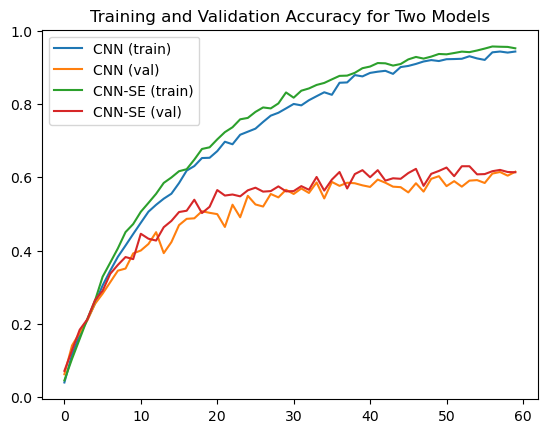

In [9]:
plt.plot(cnn_acc_record['train'], label='CNN (train)')
plt.plot(cnn_acc_record['val'], label='CNN (val)')

plt.plot(cnn_se_acc_record['train'], label='CNN-SE (train)')
plt.plot(cnn_se_acc_record['val'], label='CNN-SE (val)')

plt.title('Training and Validation Accuracy for Two Models')
plt.legend()
plt.savefig('Model_Accuracy.png')
plt.show()
